In [1]:
import numpy as np
import pypianoroll as ppr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense,Activation
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pypianoroll import Track
import matplotlib.pyplot as plt
import pickle

In [2]:
pickle_file_path = 'dataset.pickle'
# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    dataset = pickle.load(file)

In [3]:
piano_tracks=dataset["Piano"]
piano_tracks

[StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(11136, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(12096, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(10872, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(15552, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(11328, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(14784, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(8376, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(16896, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(8736, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=

In [4]:
def remove_silence(pianoroll):
    """
    Remove silent time steps (all-zero pitches) from a pianoroll.

    Parameters:
    - pianoroll (np.ndarray): Pianoroll data with shape (num_time_steps, num_pitches).

    Returns:
    - np.ndarray: Pianoroll data with silent time steps removed.
    """
    # Check if each time step is silent (all-zero pitches)
    non_silent_mask = np.any(pianoroll > 0, axis=1)

    # Extract non-silent time steps
    return pianoroll[non_silent_mask]

In [5]:
# Remove silence from each track
filtered_tracks = []
for track in piano_tracks:
    filtered_pianoroll = remove_silence(track.pianoroll)
    filtered_track = ppr.StandardTrack(name=track.name, program=track.program, is_drum=track.is_drum, pianoroll=filtered_pianoroll)
    filtered_tracks.append(filtered_track)

In [6]:
filtered_tracks

[StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(2347, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(9421, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(9720, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(14171, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(9244, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(5441, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(4300, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(14598, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(8182, 128), dtype=uint8)),
 StandardTrack(name='Piano', program=0, is_drum=False

In [7]:
pianoroll_arrays = [track.pianoroll for track in filtered_tracks]

In [8]:
pianoroll_data = np.concatenate(pianoroll_arrays, axis=0)

In [9]:
pianoroll_data.shape

(254238, 128)

In [10]:
timesteps = 10  # Number of timesteps in each sequence

scaler = MinMaxScaler(feature_range=(0, 1))
pianoroll_data_scaled = scaler.fit_transform(pianoroll_data)

# Prepare sequences and corresponding targets
X = []
y = []

for i in range(len(pianoroll_data_scaled) - timesteps):
    X.append(pianoroll_data_scaled[i:i + timesteps])
    y.append(pianoroll_data_scaled[i + timesteps])

X = np.array(X)
y = np.array(y)

print(X.shape)  # Should be (num_samples, timesteps, 128)
print(y.shape)  # Should be (num_samples, 128)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)  # Training data shape
print(X_val.shape)    # Validation data shape

(254228, 10, 128)
(254228, 128)
(203382, 10, 128)
(50846, 10, 128)


#### Simple Model

In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, 128), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(128))  # No activation function since we're doing regression
model.add(Activation('softplus'))  # Activation function to ensure non-negative output

model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### More Complicated model

In [113]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(timesteps, 128), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(128))
# model.add(Dense(128))  
# model.add(Activation('softplus'))  # Activation function to ensure non-negative output

# model.compile(optimizer='adam', loss='mean_squared_error')


#### Training

In [12]:

model.summary()

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,680 (1.07 MB)

 Trainable params: 279,680 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 110s 32ms/step - loss: 0.0232 - val_loss: 0.0042
Epoch 2/10
3178/3178 ━━━━━━━━━━━━━━━━━━━━ 98s 31ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 3/10
2319/3178 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.0018

KeyboardInterrupt: 

In [82]:
# Make predictions on the validation set
y_pred = model.predict(X_val)

# Compare the prediction with the actual value
print("Predicted:", y_pred[2])
print("Actual:", y_val[2])


1114/1114 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Predicted: [1.57197675e-04 1.27820240e-04 1.59939053e-04 1.83967160e-04
 1.05642255e-04 1.22331985e-04 1.47326398e-04 1.30455126e-04
 1.30557673e-04 1.41032826e-04 1.75611582e-04 9.98564356e-05
 1.38028219e-04 1.20813507e-04 2.19301481e-04 1.29198874e-04
 1.31304449e-04 8.69874857e-05 1.13272756e-04 1.84810444e-04
 1.10784727e-04 2.11896491e-04 1.31052759e-04 1.34517788e-04
 1.95029148e-04 6.48422807e-04 1.49823769e-04 5.64377078e-05
 2.97765573e-03 1.09003722e-05 2.01201969e-04 9.62639751e-05
 1.15616713e-04 1.54253747e-03 2.23581560e-06 5.99194864e-05
 5.27142640e-03 9.32387018e-04 2.08579586e-03 3.52212192e-05
 2.46801767e-02 6.61724014e-04 4.08481254e-04 2.99650873e-03
 1.33887155e-03 2.63536116e-03 4.31959706e-05 5.74699312e-04
 4.42049541e-02 1.01239479e-03 1.05919375e-03 6.66449545e-04
 8.71295691e-01 1.63445051e-03 3.26459180e-04 4.62666482e-01
 2.75075389e-03 2.71559181e-03 2.71897239e-04 8.24704021e-03
 6.14924669e-01 4.47856612e-04 

In [84]:
for i in range(len(y_val[2])):
    print(y_val[2][i],y_pred[2][i])

0.0 0.00015719768
0.0 0.00012782024
0.0 0.00015993905
0.0 0.00018396716
0.0 0.000105642255
0.0 0.00012233199
0.0 0.0001473264
0.0 0.00013045513
0.0 0.00013055767
0.0 0.00014103283
0.0 0.00017561158
0.0 9.9856436e-05
0.0 0.00013802822
0.0 0.00012081351
0.0 0.00021930148
0.0 0.00012919887
0.0 0.00013130445
0.0 8.6987486e-05
0.0 0.000113272756
0.0 0.00018481044
0.0 0.00011078473
0.0 0.00021189649
0.0 0.00013105276
0.0 0.00013451779
0.0 0.00019502915
0.0 0.0006484228
0.0 0.00014982377
0.0 5.6437708e-05
0.0 0.0029776557
0.0 1.0900372e-05
0.0 0.00020120197
0.0 9.6263975e-05
0.0 0.00011561671
0.0 0.0015425375
0.0 2.2358156e-06
0.0 5.9919486e-05
0.0 0.0052714264
0.0 0.000932387
0.0 0.0020857959
0.0 3.522122e-05
0.0 0.024680177
0.0 0.000661724
0.0 0.00040848125
0.0 0.0029965087
0.0 0.0013388715
0.0 0.0026353612
0.0 4.319597e-05
0.0 0.0005746993
0.0 0.044204954
0.0 0.0010123948
0.0 0.0010591937
0.0 0.00066644954
0.9224137931034483 0.8712957
0.0 0.0016344505
0.0 0.00032645918
0.5669291338582677 0

#### Generate 300 sequential samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

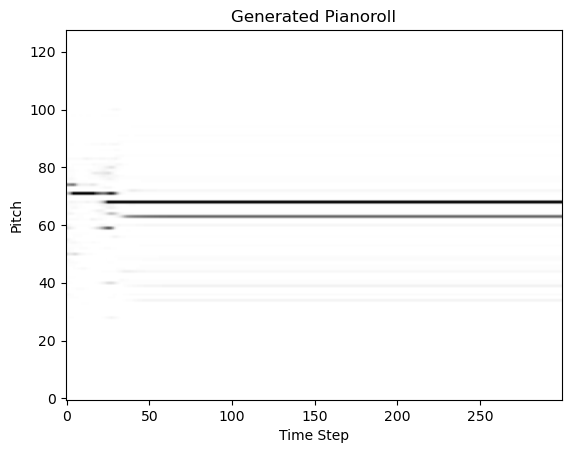

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pianoroll_data is your original data and the model is already trained

# Scale data to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
pianoroll_data_scaled = scaler.fit_transform(pianoroll_data)

timesteps = 10  # Number of timesteps in each sequence

# Generate new pianoroll data
initial_sequence = pianoroll_data_scaled[100:100+timesteps]  # Take the first 10 time steps as the initial input
generated_sequence = initial_sequence.tolist()

num_generated_steps = 300

for _ in range(num_generated_steps):
    input_sequence = np.array([generated_sequence[-timesteps:]])  # Use the last 10 steps as input
    new_step = model.predict(input_sequence)
    generated_sequence.append(new_step[0])  # Append the new step to the sequence

# Convert the generated sequence back to the original scale
generated_sequence = np.array(generated_sequence)
generated_sequence_rescaled = scaler.inverse_transform(generated_sequence)
generated_sequence_rounded = np.round(generated_sequence_rescaled)

# Clip the values to ensure they are within the range [0, 127]
generated_sequence_clipped = np.clip(generated_sequence_rounded, 0, 127).astype(int)

# Extract the generated steps (excluding the initial sequence)
generated_pianoroll = generated_sequence_clipped[timesteps:]

# Plot the generated pianoroll
plt.imshow(generated_pianoroll.T, aspect='auto', cmap='gray_r', origin='lower')
plt.title('Generated Pianoroll')
plt.xlabel('Time Step')
plt.ylabel('Pitch')
plt.show()
